In [1]:
import pyNUISANCE as pn
rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata",
    "recordpath":"/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/nue_CCPiplus_2024/submission-999999/submission.yaml"})
ana = hepdata_rec.analysis("cross_section")

Welcome to JupyROOT 6.30/04


In [3]:
probe_flux_count = ana.get_probe_flux(False)
probe_flux_count_density = ana.get_probe_flux(True)

pn.convert.ROOT.write_TH1("flux_for_t2k_nuepi.root",
                          "flux_count", probe_flux_count.spectrum,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_t2k_nuepi.root",
                          "flux_count_density", probe_flux_count_density.spectrum,False,"UPDATE")

print(probe_flux_count.probe_pdg)
print(probe_flux_count.source)
[ str(tgt) for tgt in ana.get_target() ]

12
/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/nue_CCPiplus_2024/submission-999999/best_fit_nue_flux.yaml


['1000060120[12]', '1000010010']

In [4]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_t2k_nuepi.hepmc3.gz ]; then
    neut-quickstart -t CH -s nue \
                -f flux_for_t2k_nuepi.root,flux_count \
                -n 100000 \
                -o events_for_t2k_nuepi.hepmc3.gz
fi

In [5]:
neut_events = pn.EventSource("events_for_t2k_nuepi.hepmc3.gz")
if not neut_events:
    print("Failed to read file")


In [6]:
comparison = ana.process(neut_events)
dh = comparison.data[0]
print(dh.values)
print(dh.binning.bin_sizes())
dh.values = dh.values.squeeze() * dh.binning.bin_sizes()
print(dh.values)
print(dh.project(0).values.squeeze() / dh.project(0).binning.bin_sizes())

[[ 1.1810e-41]
 [ 1.5967e-43]
 [ 2.0850e-41]
 [ 1.9175e-42]
 [ 5.0544e-43]
 [ 2.9145e-45]
 [-1.2780e-42]
 [ 2.9108e-43]]
[0.1458  3.0564  0.03645 0.7641  0.3402  7.1316  0.08505 1.7829 ]
[[ 1.72189800e-42]
 [ 4.88015388e-43]
 [ 7.59982500e-43]
 [ 1.46516175e-42]
 [ 1.71950688e-43]
 [ 2.07850482e-44]
 [-1.08693900e-43]
 [ 5.18966532e-43]]
[1.88528688e-42 8.80893540e-44]


In [8]:
import ROOT
import numpy as np

dr = ROOT.TFile("/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/nue_CCPiplus_2024/release/xsec_data_3D_fix.root")

def get_hist_vals(name):
    dh = dr.Get(name)
    return np.array([float(f"{dh.GetBinContent(i+1):.3e}") for i in range(dh.GetXaxis().GetNbins())])

all_hist = get_hist_vals("sel_best_fit")[3:]
all_p_e = get_hist_vals("sel_best_fit_elecmom")
all_cos_theta_e = get_hist_vals("sel_best_fit_eleccos")
all_p_pi = get_hist_vals("sel_best_fit_pimom")

p_e_widths = np.array([ (1.7 - 0.35), (30 - 1.7), (1.7 - 0.35), (30 - 1.7), (1.7 - 0.35), (30 - 1.7), (1.7 - 0.35), (30 - 1.7) ])
cos_theta_e_widths = np.array([ (0.94 - 0.7), (0.94 - 0.7), (1 - 0.94), (1 - 0.94), (0.94 - 0.7), (0.94 - 0.7), (1 - 0.94), (1 - 0.94) ])
p_pi_widths = np.array([ (0.45 - 0), (0.45 - 0), (0.45 - 0), (0.45 - 0), (1.5 - 0.45), (1.5 - 0.45), (1.5 - 0.45), (1.5 - 0.45) ]) * 1E3

print(f"all_hist = {all_hist}")

constructed_p_e = [ 0,0 ]
for i in [4,6,8,10]:
    constructed_p_e[0] += all_hist[i-4] * cos_theta_e_widths[i-4] * p_pi_widths[i-4]
for i in [5,7,9,11]:
    constructed_p_e[1] += all_hist[i-4] * cos_theta_e_widths[i-4] * p_pi_widths[i-4]

print(f"\nconstructed_p_e = {constructed_p_e}")
print(f"official_p_e = {all_p_e}")

constructed_cos_theta_e = [ 0,0 ]
for i in [4,5,8,9]:
    constructed_cos_theta_e[0] += all_hist[i-4] * p_e_widths[i-4] * p_pi_widths[i-4]
for i in [6,7,10,11]:
    constructed_cos_theta_e[1] += all_hist[i-4] * p_e_widths[i-4] * p_pi_widths[i-4]

print(f"\nconstructed_cos_theta_e = {constructed_cos_theta_e}")
print(f"all_cos_theta_e = {all_cos_theta_e}")

constructed_p_pi = [ 0,0 ]
for i in [4,5,6,7]:
    constructed_p_pi[0] += all_hist[i-4] * p_e_widths[i-4] * cos_theta_e_widths[i-4]
for i in [8,9,10,11]:
    constructed_p_pi[1] += all_hist[i-4] * p_e_widths[i-4] * cos_theta_e_widths[i-4]

print(f"\nconstructed_p_pi = {constructed_p_pi}")
print(f"all_p_pi = {all_p_pi}")

all_hist = [ 1.181e-41  1.597e-43  2.085e-41  1.917e-42  5.054e-43  2.915e-45
 -1.278e-42  2.911e-43]

constructed_p_e = [1.8852768000000005e-39, 8.808048000000007e-41]
official_p_e = [1.885e-39 8.809e-41]

constructed_cos_theta_e = [1.0011378225000002e-38, 4.391784150000001e-38]
all_cos_theta_e = [1.001e-38 4.392e-38]

constructed_p_pi = [9.855038400000006e-42, 5.743180800000004e-43]
all_p_pi = [9.856e-39 5.743e-40]


 -------------------------------
 | bin |      data |       err |
 -------------------------------
 |   0 | 4.649e-42 |  4.06e-82 |
 |   1 | 3.457e-43 | 1.282e-84 |
 ------------------------------- Axis lables: ["$p_e$ [GeV/c]"]
Bins: [
  0: [(0.35 - 1.70)]
  1: [(1.70 - 30.00)]
]

 -------------------------------
 | bin |      data |       err |
 -------------------------------
 |   0 | 1.819e-42 | 3.873e-83 |
 |   1 | 3.176e-42 | 3.686e-82 |
 ------------------------------- Axis lables: ["$\\cos{\\theta_e}$"]
Bins: [
  0: [(0.70 - 0.94)]
  1: [(0.94 - 1.00)]
]

 --------------------------------
 | bin |       data |       err |
 --------------------------------
 |   0 |  5.065e-42 | 3.929e-82 |
 |   1 | -6.977e-44 | 1.442e-83 |
 -------------------------------- Axis lables: ["$p_\\pi$ [GeV/c]"]
Bins: [
  0: [(0.00 - 0.45)]
  1: [(0.45 - 1.50)]
]



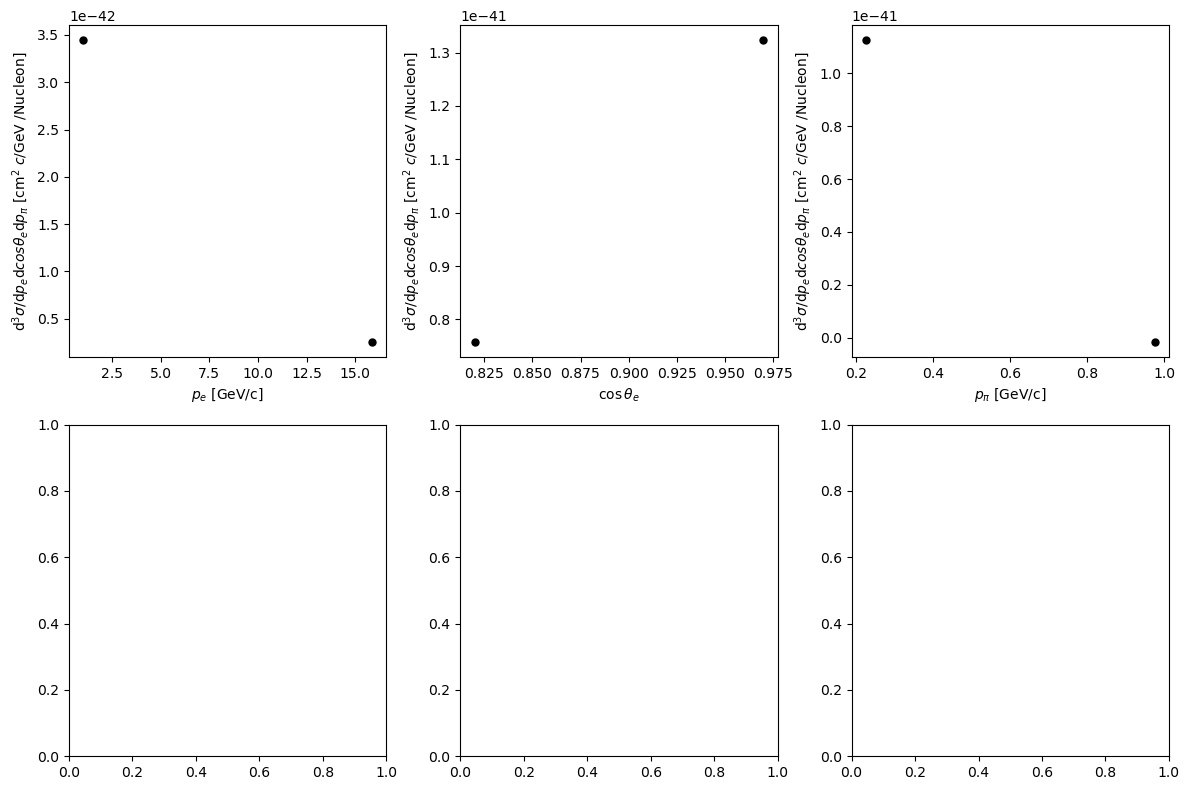

In [6]:
import matplotlib.pyplot as plt

comparison = ana.process(neut_events)

fig, axes = plt.subplots(2,3, figsize=(12,8))

d_count = comparison.data[0]
# d_count.values = d_count.values * d_count.binning.bin_sizes()

p_count = comparison.predictions[0]
p_count.values = p_count.values * p_count.binning.bin_sizes()

for i in range(3):
    d_proj = d_count.project(i)
    print(d_proj,d_proj.binning)
    # d_proj.values = d_proj.values / d_proj.binning.bin_sizes()
    d_proj.mpl().data_hist(plot_axis=axes[0][i])
    # comparison.predictions[0].project(i).mpl().hist(histtype="step", plot_axis=axes[0][i])
    # comparison.predictions[0].project(i).mpl().hist(histtype="step", plot_axis=axes[1][i])

fig.tight_layout()
fig.show()